<a href="https://colab.research.google.com/github/stanfordnmbl/mobilize-tutorials/blob/main/Tutorial_Estimating_Energy_Expenditure_During_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mobilize Center & Restore Center @ Stanford Tutorial
# Estimating Energy Expenditure During Exercise 

Physical inactivity is the fourth leading cause of global mortality. Health organizations have requested a tool to objectively measure physical activity. Respirometry and doubly labeled water accurately estimate energy expenditure, but are infeasible for everyday use. Smartwatches are portable, but have significant errors. Existing wearable methods poorly estimate time-varying activity, which comprises 40% of daily steps. We developed a Wearable System that estimates metabolic energy expenditure in real-time during common steady-state and time-varying activities with substantially lower error than state-of-the-art methods. 

The Wearable System uses inertial measurement units worn on the shank and thigh as they distinguish lower-limb activity better than wrist or trunk kinematics and converge more quickly than physiological signals. When evaluated with a diverse group of new subjects, the Wearable System has a cumulative error of 13% across common activities, significantly less than 42% for a smartwatch and 44% for an activity-specific smartwatch. This approach enables accurate physical activity monitoring which could enable new energy balance systems for weight management or large-scale activity monitoring. We will walk through how we process data from the IMUs and perform estimation of energy expenditure.

##Tutorial Overview
**In this notebook we illustrate how to analyze human motion measured by two inertial measurement units worn on one leg to estimate the calories burned during exercise.** The notebook provides a pipeline that you can adapt to get started with imu-based energy estimation projects.

The notebook is a part of the [Mobilize Center](https://mobilize.stanford.edu) webinar series, and is jointly offered with the [Restore Center](https://restore.stanford.edu). The Mobilize Center is an NIH-funded Biomedical Technology Resource Center which provides tools and training to help researchers produce insights from wearables, video, medical images, and other data sources. The Restore Center is an NIH Medical Rehabilitation Research Resource Network Center which is creating a worldwide collaboration to advance the use of real-world data in rehabilitation outcomes for those with movement impairments.

##Background and Citation
Most of the [code](https://github.com/pslade2/EnergyExpenditure) in this notebook comes from our study on estimating energy expenditure during exercise. To cite our work, please use:

*Slade, P., Kochenderfer, M.J., Delp, S.L., Collins, S.. Sensing leg movement enhances wearable monitoring of energy expenditure. Nat Commun 12, 4312 (2021).*

Learn more about this work:
* [Read our publication](https://www.nature.com/articles/s41467-021-24173-x)
* [See our hardware documentation](https://spectrum.ieee.org/a-diy-calorie-counter-more-accurate-than-a-smartphone)

## Learning Goals

In this tutorial notebook, you will learn how to:

* Perform the protocol to collect data from two inertial measurement units
  - Selecting sensors
  - Placement of sensors
* Understanding inertial measurement unit data for lower-extremity movement
  - Loading and formatting time series IMU data
  - Understanding IMU signals during lower-limb movement
* Preprocessing movement data
  - Segmenting cyclic movement by gait cycle
  - Filter lower-limb movement data
  - Format data for each gait cycle
* Intuition behind the data-driven model
  - Plot the weights of the model to understand what information it uses from the sensors
* Estimate energy expenditure
  - Use the model to estimate energy expenditure. Plot respirometry per breath and ground truth. 
  - Explore time-varying estimation

# Setup




## Introduction to Google Colab

Google Colab is a cloud-based environment for running Python code interactively (via Jupyter notebooks, for those who are familiar with those). If you are new to Colab, you can learn about the key features in [this tutorial](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). For the purposes of our tutorial, you only need to understand how to interact with the "code cells." 

The data for this tutorial are store on a [Github repository](https://github.com/stanfordnmbl/mobilize-tutorials-data)

In [1]:
# Installing and loading necessary packages and data files
from scipy import signal
import numpy as np
import time
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
!git clone https://github.com/stanfordnmbl/mobilize-tutorials-data.git
drive_path = '/content/mobilize-tutorials-data/' # path to folder containing code and data

Cloning into 'mobilize-tutorials-data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


# Protocol for Collecting Data

## Sensors and Hardware

The wearable system we used to estimate energy expenditure consisted of two inertial measurement unit (IMU) sensors, a microcontroller (Raspberry Pi), and rechargeable battery. The details of the components we selected are available in [this article](https://spectrum.ieee.org/a-diy-calorie-counter-more-accurate-than-a-smartphone). 

The components we have selected can be replaced with others, but may require modifications to the code we provide. In order to provide sufficient sensing to capture dynamic movement like running, you should select inertial measurement units that can measure +/-16G of acceleration, +/- 2000 degrees per second of rotation, and that can sample data at a rate of at least 50 Hz.

## Placement of Sensors

The IMUs were placed on the lateral side of the left leg, one in the middle of the thigh, and the other on the middle of the shank. The inertial measurement units consist of a three-axis accelerometer (accel) and a three-axis gyroscope (gyro). The IMUs were oriented so that the X, Y, and Z directions represent the fore-aft, mediolateral, and vertical axes, respectively. These orientations are assigned during quiet standing, but the sensors are attached to different body parts that move relative to the global reference frame. 

It is important to note that the accuracy of the calorie estimates are sensitive to the placement of the IMUs. For example, misalignment of the three axes changed estimates by a large amount, so the training data for the data-driven model was augmented with random small rotations to provide a model that was more robust to small errors in placement. Translation of the sensor along the vertical axis resulted in only very small changes in error. 

For use with other patient populations, we recommend following the axes alignment as closely as possible. Making distal or proximal translations to sensor placement should have little impact on the device performance. 

# Understanding Inertial Measurement Unit Data for Lower-Extremity Movement



## Loading and Formatting Time Series IMU Data

We will now load pre-recorded IMU data. This data is the raw time series recorded at 100 Hz during walking. We recommend a minimum sampling rate of 50 Hz to capture dynamic activities like running.

In [2]:
walking_data_path = drive_path+'energyExpenditureData/walk_sample.csv'
raw_IMU_data = np.loadtxt(walking_data_path, delimiter=',')
print(raw_IMU_data.shape)

(35500, 13)


Now we have loaded the CSV file containing the walking data sample. The size indicates that there are 13 time-series signals (colums) with 35,500 samples (rows) for each signal. These signals, in order, are the three signals from the gyroscope on the shank (x,y,z axes signals), the three signals from the gyroscope on the thigh (x,y,z axes signals), the three signals from the accelerometer on the thigh (x,y,z axes signals), the three signals from the accelerometer on the shank (x,y,z axes signals), and 1 signal to indicate corrupted messages. Since we sampled data at 100 Hz, that means this file is approximately 355 seconds or about 6 minutes. If you would like to use sensor data from a different sensor, format the samples and signals into the same rows and columns format defined here to be able to use the following processing code.

## Understanding IMU Signals During Lower-limb Movement

Now we will plot the different signals to visualize the raw data. Notice that the signals are cyclic, repeat approximately every 120 samples. This is because as the person walks, their leg moves in the same way with each step. Motion in the sagittal plane is associated with the z-axis measurements, we can see that these signals have the largest rates of rotation. The vertical axis measurements of acceleration (y-axis) show large spikes when the leg comes in contact with the ground.

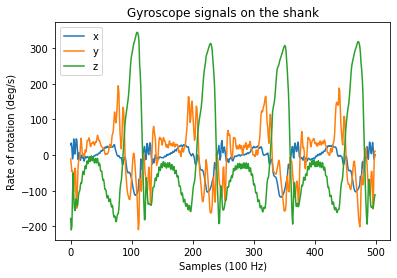

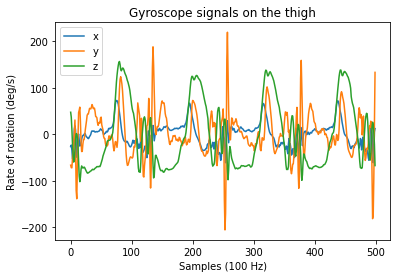

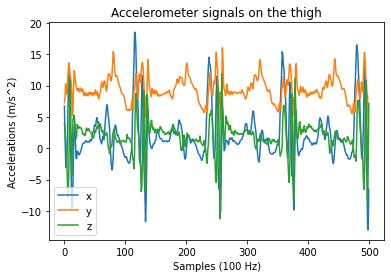

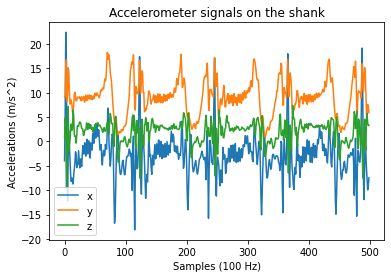

In [3]:
plot_start = 5000 # Sample number to start plotting from
plot_length = 500 # Number of samples to plot (seconds * 100)

plt.figure() 
plt.title('Gyroscope signals on the shank')
plt.plot(raw_IMU_data[plot_start:plot_start+plot_length,0:3])
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Rate of rotation (deg/s)')
plt.legend(['x','y','z'])
plt.show()

plt.figure() 
plt.title('Gyroscope signals on the thigh')
plt.plot(raw_IMU_data[plot_start:plot_start+plot_length,3:6])
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Rate of rotation (deg/s)')
plt.legend(['x','y','z'])
plt.show()

plt.figure() 
plt.title('Accelerometer signals on the thigh')
plt.plot(raw_IMU_data[plot_start:plot_start+plot_length,6:9])
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Accelerations (m/s^2)')
plt.legend(['x','y','z'])
plt.show()

plt.figure() 
plt.title('Accelerometer signals on the shank')
plt.plot(raw_IMU_data[plot_start:plot_start+plot_length,9:12])
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Accelerations (m/s^2)')
plt.legend(['x','y','z'])
plt.show()

# Preprocessing Movement Data

Next we will look at steps to preprocess our IMU data to extract the essential information about the movements. This will include filtering the signals to remove noise and segmenting the periodic motions into strides, also called gait cycles.

## Filter Lower-Limb Movement Data

You'll notice that the raw IMU signals do not appear very smooth, most have small perturbations which is often called sensor noise. This noise is due to many factors including the sensitivity of the sensors (even resting sensors have noise) and high frequency components of motion such as slight vibration or shifting of the sensor when in contact with the person due to shifting clothing or skin.

We will use a low-pass filter to eliminate these higher frequencies of noise and isolate only a portion of lower-frequency signal associated with movement. Here, we use a common low-pass filter to isolate a signal of 6 Hz or less, which is standard for filtering movement data for walking or running. For our tasks of walking, running, biking, and stair climbing that works well. For higher speed tasks like sprinting, you may want to pick a higher value.

Notice in the plot below, the filtered signal appears much smoother but retains the same general shape of the unfiltered signal.

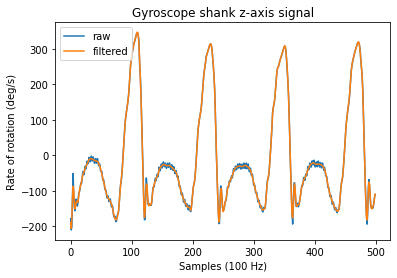

In [4]:
wn = 20 # Crossover frequency for low-pass filter (Hz)
filt_order = 4 # Fourth order filter
sample_freq = 100 # in Hz *Change this value if you use a different sample frequency*
b,a = signal.butter(filt_order, wn, fs=sample_freq) # params for low-pass filter
filtered_data = signal.filtfilt(b,a,raw_IMU_data[:,:-1], axis=0)
shank_gyro_z_index = 2 # column number for z-axis of shank gyroscope readings used to segment gait cycle

plt.figure() 
plt.title('Gyroscope shank z-axis signal')
plt.plot(raw_IMU_data[plot_start:plot_start+plot_length,shank_gyro_z_index])
plt.plot(filtered_data[plot_start:plot_start+plot_length,shank_gyro_z_index])
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Rate of rotation (deg/s)')
plt.legend(['raw','filtered'])
plt.show()

## Segmenting Cyclic Movement by Gait Cycle

Next, we'll segment periodic movements by gait cycle. This is often done with a measure of ground reaction forces when the heel of the foot strikes the ground. With wearable sensors like IMUs, we will instead use change in rotation of the leg right before heelstrike. Specifically, the sagittal plane rotation of the shank IMU. Immediately before heel strike the leg stops swinging forward and starts to move backwards. This change in rotational direction creates a peak in the angular velocity of the shank. In the plot below we use a simple find peaks function that uses a threshold and minimum distance between peaks to automatically segment this movement. 

We selected a threshold of 70 deg/s which reliably segmented gait cycles from slow walking at 0.7 m/s to running at 3.25 m/s and worked well for cycling and stair climbing. If you plan to use this approach for participants moving very slowly, you may need to adjust this threshold. The minimum distance between peaks corresponds to the fastest expected gait cycle. Here we selected a minimum gait cycle of 0.6 seconds, which was a smaller value than the shortest gait cycle we recorded. If you plan to evaluate motion that is much faster or slower, you may need to adjust this value. 

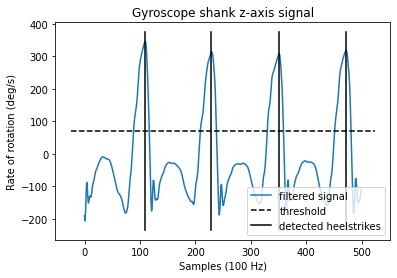

In [5]:
peak_height_thresh = 70 # minimum value of the shank IMU gyro-Z reading in deg/s
peak_min_dist = int(0.6*sample_freq) # min number of samples between peaks

peak_index_list = signal.find_peaks(filtered_data[:,shank_gyro_z_index], height=peak_height_thresh, distance=peak_min_dist)[0]
peak_index_list_plot = signal.find_peaks(filtered_data[plot_start:plot_start+plot_length,shank_gyro_z_index], height=peak_height_thresh, distance=peak_min_dist)[0]

plt.figure() 
plt.title('Gyroscope shank z-axis signal')
plt.plot(filtered_data[plot_start:plot_start+plot_length,shank_gyro_z_index])
axes = plt.gca()
ymin, ymax = axes.get_ylim()
xmin, xmax = axes.get_xlim()
plt.plot([xmin,xmax],[peak_height_thresh, peak_height_thresh], color='k',ls='--')
for i in peak_index_list_plot:
    plt.plot([i,i],[ymin,ymax],color='k')
plt.xlabel('Samples (100 Hz)')
plt.ylabel('Rate of rotation (deg/s)')
plt.legend(['filtered signal','threshold','detected heelstrikes'],loc='lower right')
plt.show()

## Format Data for Each Gait Cycle

Now that we have segmented movement by gait cycle, we will format the data to pass into our estimation model. The duration of gait cycles changes depending on walking speed and activity, but our estimation model uses a fixed input size. We perform a time-invariant formatting to adjust varying lengths of gait cycles into one fixed size, by averaging the measurements across a gait cycle into a set number of discrete bins. In this case we use 30 bins to capture sufficient detail about the movement. Our experiments found that increasing the number of bins did not improve model performance for our application. Fewer bins resulted in worse performance, likely due to a loss of detailed information about movements. Run the following cell to process the time-series data into a time-invariant format. 

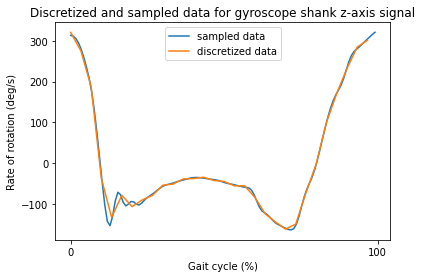

Format for processed gait data: (363, 286)


In [6]:
stride_detect_window = 4*sample_freq # maximum time length for strides (seconds * samples/second)
gait_cnt = 0 # keep track of the number of gait cycles
num_bins = 30 # number of bins to discretize one gait cycle of data from each signal into a fixed size
gait_data = np.zeros((3+12*num_bins, 1000)) # storage for up to 1000 gait cycles of formatted data 
weight = 68 # participant bodyweight in kg
height = 1.74 # participant height in m
deg2rad = 0.0174533 # rad / deg

# process time series data, format units, and discretize each gait cycle into a fixed number of discrete bins
def processRawGait(data_array, start_ind, end_ind, b, a, weight, height, num_bins=30):
    gait_data = data_array[start_ind:end_ind, :] # crop to the gait cycle
    gait_data = gait_data*np.array([deg2rad,-deg2rad,-deg2rad,deg2rad,-deg2rad,-deg2rad,1,-1,-1,1,-1,-1]) # flip y & z, convert to rad/s
    bin_gait = signal.resample(gait_data, num_bins, axis=0) # resample gait cycle of data into fixed number of bins along axis = 0 by default
    shift_flip_bin_gait = bin_gait.transpose() # get in shape of [feats x bins] for correct flattening
    model_input = shift_flip_bin_gait.flatten()
    model_input = np.insert(model_input, 0, [1.0, weight, height]) # adding a 1 for the bias term at start
    return model_input

for i in range(len(peak_index_list)-1): # looping through each gait cycle of data
    gait_start_index = peak_index_list[i] # index at start of gait
    gait_stop_index = peak_index_list[i+1] # index at end of gait
    if (gait_stop_index - gait_start_index) <= stride_detect_window: # if gait cycle within maximum time allowed
        gait_data[:,gait_cnt] = processRawGait(filtered_data, gait_start_index, gait_stop_index, b, a, weight, height, num_bins)
        gait_cnt += 1 # increment number of gait cycles of data stored
gait_data = gait_data[:,:gait_cnt] # get rid of empty storage

# Plotting discretized and continuous sampled data for one gait cycle
gait_cycle_to_plot = 1
plt.figure() 
plt.title('Discretized and sampled data for gyroscope shank z-axis signal')
start_gait_index = peak_index_list[gait_cycle_to_plot]
stop_gait_index = peak_index_list[gait_cycle_to_plot+1]
plt.plot(filtered_data[start_gait_index:stop_gait_index,shank_gyro_z_index])

# plotting discretized data
gait_length = stop_gait_index - start_gait_index
x = np.linspace(start=0,stop=gait_length,num=num_bins+1)
bin = 2
plt.plot(x[:-1], gait_data[3+num_bins*bin:3+num_bins*(bin+1),gait_cycle_to_plot]*(-1/deg2rad))
plt.xticks(ticks=[0,gait_length],labels=[0,100])
plt.xlabel('Gait cycle (%)')
plt.ylabel('Rate of rotation (deg/s)')
plt.legend(['sampled data', 'discretized data'])
plt.show()

print("Format for processed gait data:",gait_data.shape)

Notice the shape of the processed gait data is (363, X). The length of processed data for each gait cycle is 363 values. The first three are the duration of the gait cycle (in seconds), the subject weight, and the subject height. Then the next 360 values are comprised of the 30 bins recording one gait cycle of data for the 12 signals of the thigh and shank IMUs. The value for X is the number of gait cycles recorded during the condition.

# Intuition Behind the Data-Driven Model

The Wearable System used a linear regression model to estimate energy expenditure with inputs from the IMU signals worn on the shank and thigh. A larger magnitude weight indicated a more informative input. The input signals are shown in descending order of importance based on contribution to total model weight. Gyroscope inputs were more informative than accelerations. The X, Y, and Z directions represent the fore-aft, mediolateral, and vertical axes, respectively. Run the following cell to visualize the model weights.

***Hand-tune a simple model to detect walk vs run for trying it on their own. See what all will fit in 25 min time block. Engaging if there is interaction, maybe change values in an array or something. How you apply and set weights could provide learning. If we change age or weight, what does the model change? Bias in entering incorrectly. Changing self-entered data? 

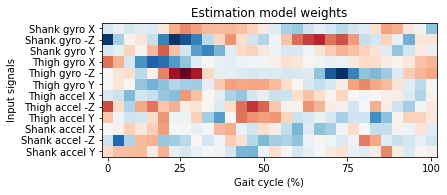

In [7]:
model_dir = drive_path+'energyExpenditureData/full_fold_aug/' # path to model weights
model_weights = np.loadtxt(model_dir + 'weights.csv', delimiter=',') # model weight vector
weights_unnorm = model_weights[3:] # get rid of bias and height/weight offset
unnorm_weights = np.reshape(weights_unnorm,(-1,num_bins))

pelv_x_dir = " Z"# dir"
pelv_y_dir = " Y"# dir"
pelv_z_dir = " -X"# dir"
thigh_x_dir = " X"# dir"
thigh_y_dir = " -Z"#-dir"
thigh_z_dir = " Y"#-dir"
shank_x_dir = " X"#-dir"
shank_y_dir = " -Z"#-dir"
shank_z_dir = " Y"#-dir"
thigh = "Thigh"
shank = "Shank"
accel = " accel"
gryo = " gyro"

full_features = ['bias','weight','height',
                 shank+gryo+shank_x_dir,shank+gryo+shank_y_dir,shank+gryo+shank_z_dir,
                 thigh+gryo+thigh_x_dir,thigh+gryo+thigh_y_dir,thigh+gryo+thigh_z_dir,
                 thigh+accel+thigh_x_dir,thigh+accel+thigh_y_dir,thigh+accel+thigh_z_dir,
                 shank+accel+shank_x_dir,shank+accel+shank_y_dir,shank+accel+shank_z_dir]

plt.figure()
plt.imshow(unnorm_weights, cmap='RdBu')

xticks = [0,6.5,14,21.5,29]
yticks=[0,1,2,3,4,5,6,7,8,9,10,11]
gait_labels = ['0','25','50','75','100']
plt.yticks(ticks=yticks, labels=full_features[3:])
plt.xticks(ticks=xticks, labels=gait_labels)
plt.ylabel("Input signals")
plt.xlabel("Gait cycle (%)")
plt.title("Estimation model weights")
plt.show()

# Estimating Energy Expenditure

We will now pass the formatted data into the data-driven model to estimate the energy expended with each gait cycle.

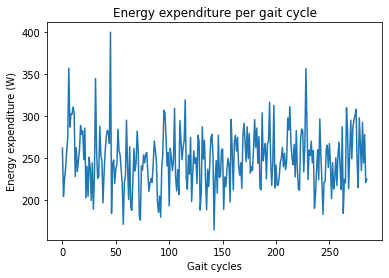

In [8]:
estimates = np.zeros(gait_cnt)
for i in range(gait_cnt):
    estimates[i] = np.dot(gait_data[:,i], model_weights)

plt.figure()
plt.plot(estimates)
plt.title("Energy expenditure per gait cycle")
plt.xlabel("Gait cycles")
plt.ylabel("Energy expenditure (W)")
plt.show()

We will now compare the energy expenditure estimates to ground truth respirometry measurements collected in the lab. We see that the steady-state respirometry is quite close to the estimated energy expenditure from our model. You will also notice a slight delay in the respirometry 

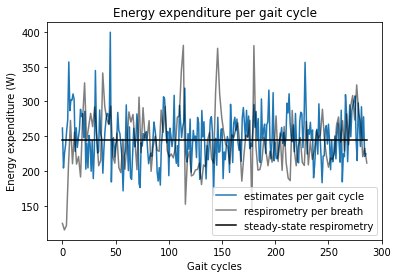

In [9]:
metabolics_breaths = np.loadtxt(drive_path+'energyExpenditureData/walking_metabolics.csv', delimiter=',', skiprows=1) 
avg_metabolics = np.mean(metabolics_breaths[len(metabolics_breaths)//2:])

plt.figure()
plt.plot(estimates)
plt.title("Energy expenditure per gait cycle")
plt.xlabel("Gait cycles")
plt.ylabel("Energy expenditure (W)")
plt.plot(np.linspace(start=0,stop=len(estimates),num=len(metabolics_breaths)),metabolics_breaths, c='k', alpha=0.5)
plt.plot([0,len(estimates)],[avg_metabolics, avg_metabolics], c='k')
plt.legend(['estimates per gait cycle', 'respirometry per breath','steady-state respirometry'])
plt.show()

## Exploring Time-Varying Activities

Now, you can experiment with different conditions of data to see the results for running, stair climbing, biking, and time-varying conditions. We'll specifically look at a time-varying condition where participants transitioned between walking and running, following a step function speed profile with a period of 30 seconds. Notice how the energy expenditure changes smoothly between the speeds.

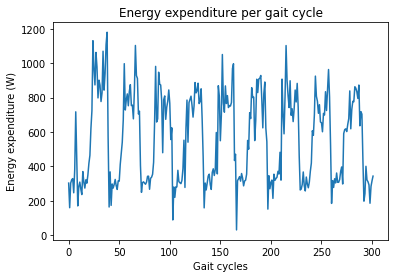

In [10]:
walking_data_path = drive_path+'energyExpenditureData/walk_to_run_sample.csv'
raw_IMU_data = np.loadtxt(walking_data_path, delimiter=',')

b,a = signal.butter(filt_order, wn, fs=sample_freq) # params for low-pass filter
filtered_data = signal.filtfilt(b,a,raw_IMU_data[:,:-1], axis=0)
shank_gyro_z_index = 2 # column number for z-axis of shank gyroscope readings used to segment gait cycle

peak_index_list = signal.find_peaks(filtered_data[:,shank_gyro_z_index], height=peak_height_thresh, distance=peak_min_dist)[0]
peak_index_list_plot = signal.find_peaks(filtered_data[plot_start:plot_start+plot_length,shank_gyro_z_index], height=peak_height_thresh, distance=peak_min_dist)[0]

gait_data = np.zeros((3+12*num_bins, 1000)) # storage for up to 1000 gait cycles of formatted data 
gait_cnt = 0
for i in range(len(peak_index_list)-1): # looping through each gait cycle of data
    gait_start_index = peak_index_list[i] # index at start of gait
    gait_stop_index = peak_index_list[i+1] # index at end of gait
    if (gait_stop_index - gait_start_index) <= stride_detect_window: # if gait cycle within maximum time allowed
        gait_data[:,gait_cnt] = processRawGait(filtered_data, gait_start_index, gait_stop_index, b, a, weight, height, num_bins)
        gait_cnt += 1 # increment number of gait cycles of data stored
gait_data = gait_data[:,:gait_cnt] # get rid of empty storage

estimates = np.zeros(gait_cnt)
for i in range(gait_cnt):
    estimates[i] = np.dot(gait_data[:,i], model_weights)

plt.figure()
plt.plot(estimates)
plt.title("Energy expenditure per gait cycle")
plt.xlabel("Gait cycles")
plt.ylabel("Energy expenditure (W)")
plt.show()

# Open-Ended Questions

1.   How does the model depend on subject specific parameters like height and weight? 
2.   How could you use the model to determine the importance of a single signal?
3.   What would happen if two activities had the exact same motion (e.g. biking with a different resistance level but at the same pedaling frequency)?
4.   What additional information could you incorporate to differentiate between activities with similar motions? 
5.   How might you include that additional information in the model?



#Feedback

This notebook is a work-in-progress and we welcome your feedback on how to increase its usefulness. Email comments to us at [mobilize-center@stanford.edu](mailto:mobilize-center@stanford.edu) or submit an issue on GitHub.



---



*Version* 1.03

Creator: Patrick Slade | Contributors: Patrick Slade, Joy Ku, Matt Petrucci  
Last Updated on April 25, 2022

This notebook is made available under the [Apache 2.0 license](https://www.apache.org/licenses/LICENSE-2.0).